# 02. Preprocessing & Feature Engineering

Generates features (MA, RSI, Lags) and prepares train/test splits.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
from utils.data_manager import DataManager

%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (15, 7)


## 1. Load Raw Data

In [2]:
dm_raw = DataManager(data_type='raw', local_dir=os.path.join(root_path, 'data/raw'))
df = dm_raw.get_latest_data(force_refresh=False)
if not df.empty:
    # Tuple-String Cleanup
    new_cols = []
    for c in df.columns:
        c = str(c)
        if (c.startswith("('") or c.startswith('("')) and "," in c:
            clean = c.strip("()").replace("'", "").replace('"', "").split(",")[0].strip()
            new_cols.append(clean)
        else:
            new_cols.append(c)
    df.columns = new_cols
    
    # Deduplicate
    df = df.loc[:, ~df.columns.duplicated()]
print(f"Loaded {len(df)} rows.")

# Clean tuples/volume
tuple_cols = [c for c in df.columns if isinstance(c, tuple) or (isinstance(c, str) and c.startswith('('))]
if tuple_cols: df = df.drop(columns=tuple_cols)
if 'Volume' in df.columns: df = df.drop(columns=['Volume'])

# Ensure numeric Close
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])

# Filter out zero or negative prices to avoid infinity in pct_change
df = df[df['Close'] > 0]



Loaded 1307 rows.


## 2. Feature Engineering

In [3]:
# 1. Returns
df['Return'] = df['Close'].pct_change()

# 2. Moving Averages
for ma in [5, 10, 20, 50]:
    df[f'MA_{ma}'] = df['Close'].rolling(window=ma).mean()

# 3. RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['Close'])

# 4. Lagged Returns
for r in [5, 20]:
    df[f'Return_{r}d'] = df['Close'].pct_change(periods=r)

for lag in [1, 2, 3, 5]:
    df[f'Lag_{lag}'] = df['Return'].shift(lag)

df = df.dropna()

# Preserve Unscaled Return for ARIMA
df['Return_Unscaled'] = df['Return']
# Preserve Unscaled Close for Reconstruction/Horizon
df['Close_Unscaled'] = df['Close']


print(f"Rows after Feature Engineering: {len(df)}")


Rows after Feature Engineering: 1258


## 3. Feature Visualization

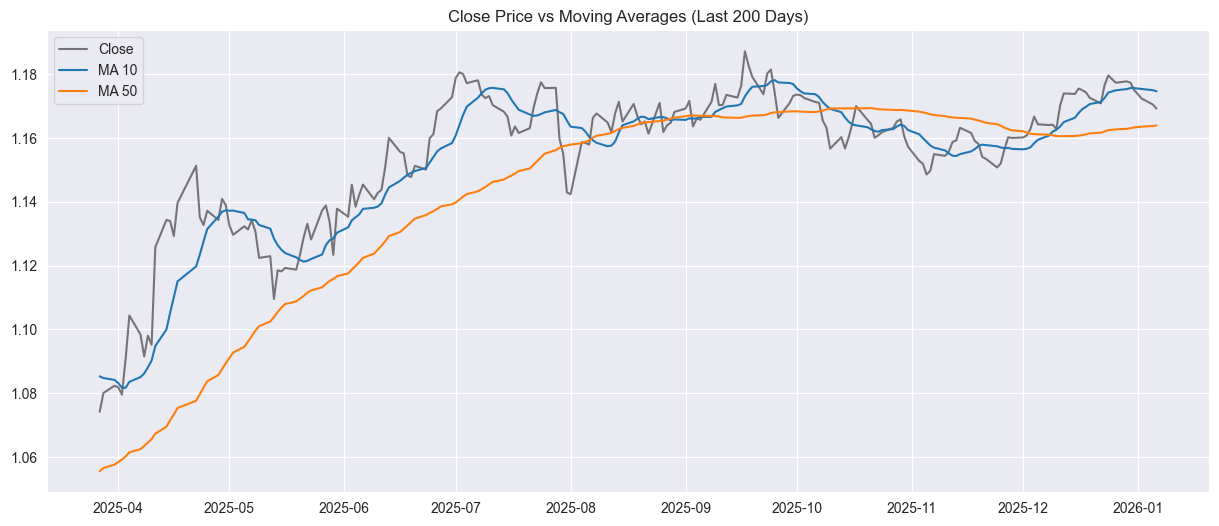

In [4]:
# Plot Moving Averages
plt.figure(figsize=(15, 6))
plt.plot(df.index[-200:], df['Close'].iloc[-200:], label='Close', color='black', alpha=0.5)
plt.plot(df.index[-200:], df['MA_10'].iloc[-200:], label='MA 10')
plt.plot(df.index[-200:], df['MA_50'].iloc[-200:], label='MA 50')
plt.title("Close Price vs Moving Averages (Last 200 Days)")
plt.legend()
plt.show()


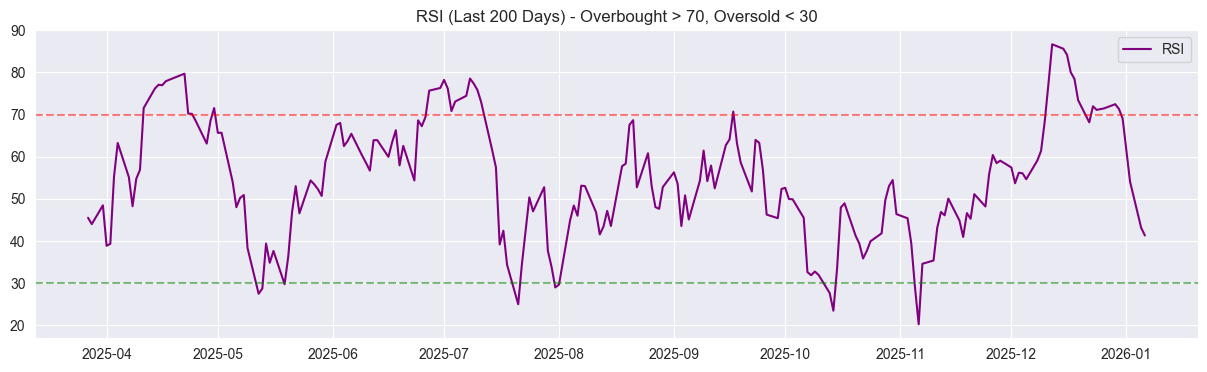

In [5]:
# Plot RSI
plt.figure(figsize=(15, 4))
plt.plot(df.index[-200:], df['RSI'].iloc[-200:], color='purple', label='RSI')
plt.axhline(70, linestyle='--', color='red', alpha=0.5)
plt.axhline(30, linestyle='--', color='green', alpha=0.5)
plt.title("RSI (Last 200 Days) - Overbought > 70, Oversold < 30")
plt.legend()
plt.show()


### Correlation Heatmap (Original)

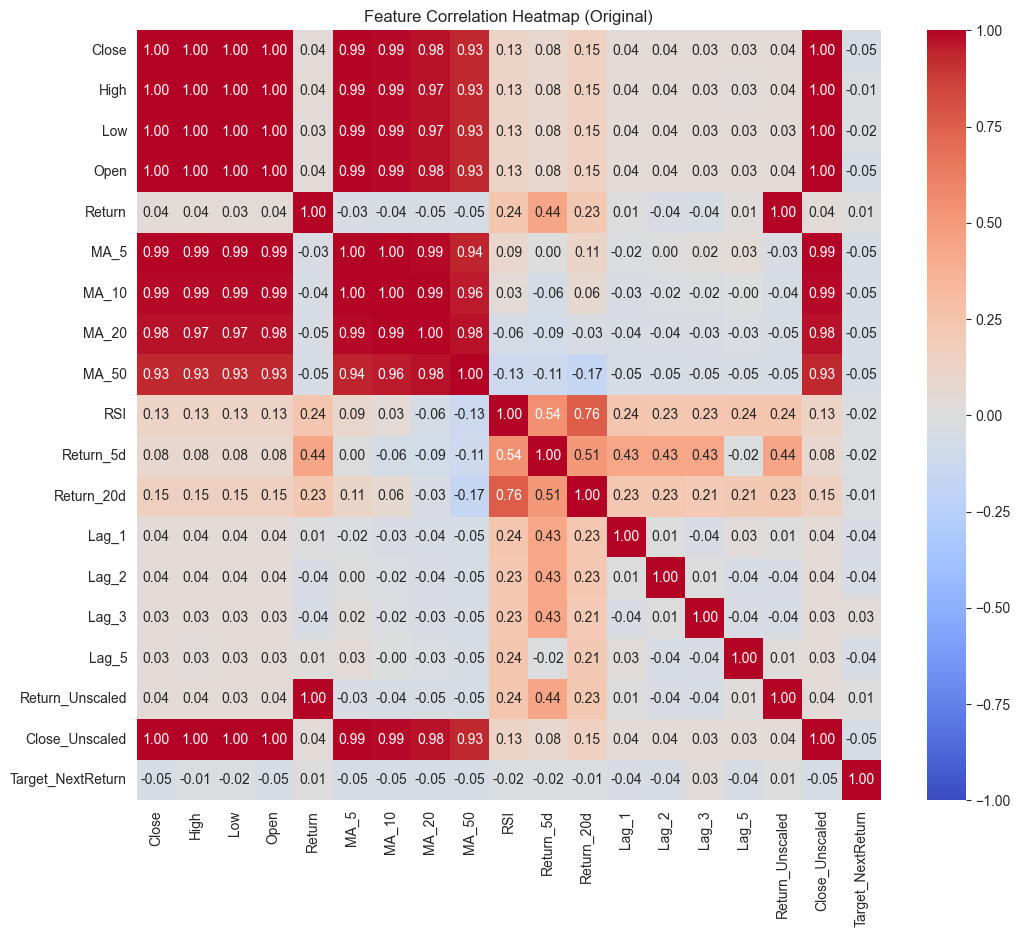

In [6]:
plt.figure(figsize=(12, 10))
# Create Target for correlation check
df['Target_NextReturn'] = df['Return'].shift(-1)
temp_df = df.dropna().copy()
feature_cols_all = [c for c in temp_df.columns if c not in ['Target_NextReturn']]

# Heatmap
corr_all = temp_df[feature_cols_all + ['Target_NextReturn']].corr()
sns.heatmap(corr_all, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap (Original)")
plt.show()

# Clean up temp target
df = df.drop(columns=['Target_NextReturn'])


### Correlation Reduction (Drop > 0.95)

We identify highly correlated features and drop the redundant ones (keeping the one best correlated with Target).

In [7]:
# 1. Create Target temporarily
df['Target_NextReturn'] = df['Return'].shift(-1)
temp_df = df.dropna().copy()

# 2. Exclude essential columns from dropping
# We MUST keep 'Return' because it's used to create Target later.
keep_cols = ['Open', 'High', 'Low', 'Close', 'Return', 'Return_Unscaled', 'Target', 'Target_NextReturn']
feature_cols = [c for c in temp_df.columns if c not in keep_cols]

# 3. Calculate Correlation
corr_matrix = temp_df[feature_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = []
threshold = 0.95
drop_records = []

print(f"🔍 Checking correlations > {threshold}...")

target_corr = temp_df[feature_cols + ['Target_NextReturn']].corr()['Target_NextReturn'].abs()

for column in upper.columns:
    if any(upper[column] > threshold):
        correlated_feats = upper.index[upper[column] > threshold].tolist()
        
        current_score = target_corr.get(column, 0)
        
        for feat in correlated_feats:
            peer_score = target_corr.get(feat, 0)
            
            if feat in to_drop: continue # Already dropped
            
            if current_score < peer_score:
                if column not in to_drop:
                    to_drop.append(column)
                    drop_records.append({'Drop': column, 'Keep': feat, 'Corr': upper.loc[feat, column], 'Score_Drop': current_score, 'Score_Keep': peer_score})
            else:
                if feat not in to_drop:
                    to_drop.append(feat)
                    drop_records.append({'Drop': feat, 'Keep': column, 'Corr': upper.loc[feat, column], 'Score_Drop': peer_score, 'Score_Keep': current_score})

# Show Summary Table
if drop_records:
    drop_df = pd.DataFrame(drop_records).sort_values('Corr', ascending=False)
    print("🔻 Feature Reduction Summary:")
    display(drop_df)
else:
    print("✅ No highly correlated features found to drop.")

# Deduplicate list
to_drop = list(set(to_drop))
df = df.drop(columns=to_drop)
df = df.drop(columns=['Target_NextReturn']) # Cleanup

print(f"✅ Final Features: {[c for c in df.columns if c not in ['Open','High','Low','Close','Return_Unscaled','Target']]}")


🔍 Checking correlations > 0.95...
🔻 Feature Reduction Summary:


,Drop,Keep,Corr,Score_Drop,Score_Keep
0,MA_10,MA_5,0.996591,0.048898,0.050489
2,MA_5,Close_Unscaled,0.994937,0.050489,0.053131
1,MA_20,MA_5,0.985381,0.048183,0.050489


✅ Final Features: ['Return', 'MA_50', 'RSI', 'Return_5d', 'Return_20d', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_5', 'Close_Unscaled']


### Correlation Heatmap (Cleaned)

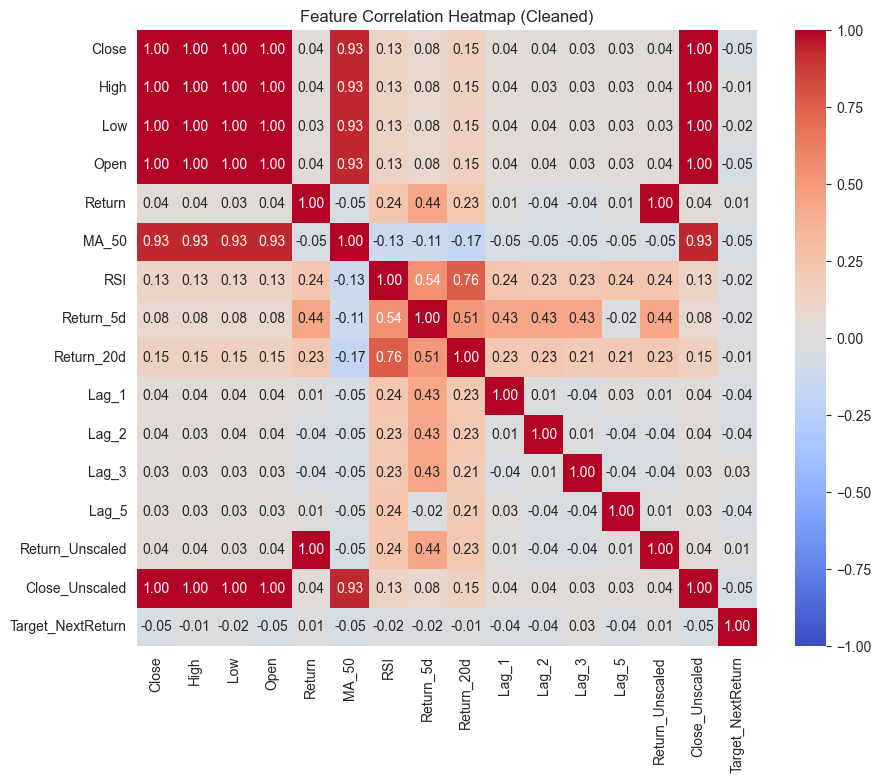

In [8]:
plt.figure(figsize=(10, 8))
# Re-calc Target for Viz
df['Target_NextReturn'] = df['Return'].shift(-1)
# features now are whatever is left in df (excluding basics)
final_cols = [c for c in df.columns if c not in ['Target_NextReturn']]

corr_final = df[final_cols + ['Target_NextReturn']].corr()
sns.heatmap(corr_final, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap (Cleaned)")
plt.show()

df = df.drop(columns=['Target_NextReturn'])


## 4. Train/Test Split & Save

Train Size: 1005
Test Size: 252
✅ Saved processed data.


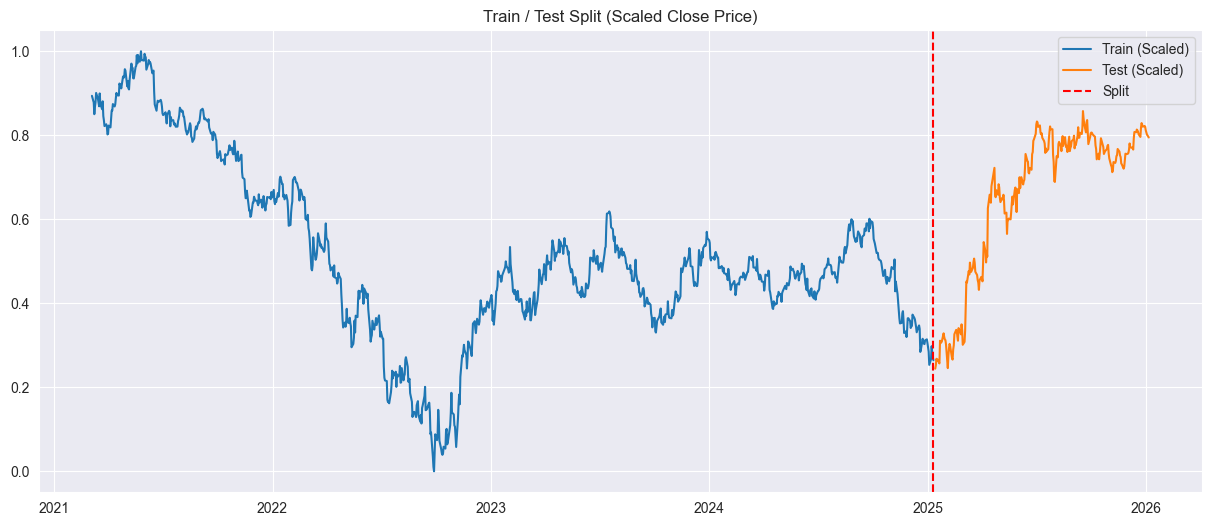

In [9]:
# Target
df['Target'] = df['Return'].shift(-1)
df = df.dropna()

train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

print(f"Train Size: {len(train_df)}")
print(f"Test Size: {len(test_df)}")

# Scaling
scaler = MinMaxScaler()
cols_to_scale = [c for c in df.columns if c not in ['Target', 'Return_Unscaled']] # Exclude Unscaled Return
train_df[cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale])
test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])

# Save
dm_processed = DataManager(data_type='processed', local_dir=os.path.join(root_path, 'data/processed'))
dm_processed.save_processed(train_df, test_df, scaler, metadata={'version': 'notebook'})
print("✅ Saved processed data.")

# Visualize Split
plt.figure(figsize=(15, 6))
plt.plot(train_df.index, train_df['Close'], label='Train (Scaled)') # Note: It's scaled now, visualization might be weird for Price
plt.plot(test_df.index, test_df['Close'], label='Test (Scaled)')
plt.axvline(train_df.index.max(), color='red', linestyle='--', label='Split')
plt.title("Train / Test Split (Scaled Close Price)")
plt.legend()
plt.show()
